In [1]:
# following https://towardsdatascience.com/bayesian-logistic-regression-with-pymc3-8e17c576f31a
# data from https://archive.ics.uci.edu/ml/datasets/Occupancy+Detection+

In [2]:
!pwd

/Users/spx8sk/work/git/stk/ml/bayes/logistic-reg-pymc3


In [3]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn
import theano.tensor as tt
import warnings
from IPython.core.pylabtools import figsize
import seaborn as sns
from sklearn.metrics import (roc_curve, roc_auc_score, confusion_matrix, accuracy_score, f1_score, 
                             precision_recall_curve) 
from sklearn.metrics import confusion_matrix

In [4]:
# read data

In [5]:
df = pd.read_csv("./occupancy_data/datatest.txt")

In [6]:
df.sample(5)

date  Temperature  Humidity  Light     CO2  \
2356  2015-02-04 03:15:00        20.70    24.790    0.0  484.80   
1934  2015-02-03 20:12:59        21.20    27.340    0.0  737.75   
1286  2015-02-03 09:24:59        21.20    26.245  439.0  849.00   
1051  2015-02-03 05:30:00        20.29    22.600    0.0  435.50   
2369  2015-02-04 03:28:00        20.70    24.675    0.0  479.25   

      HumidityRatio  Occupancy  
2356       0.003739          0  
1934       0.004255          0  
1286       0.004084          1  
1051       0.003321          0  
2369       0.003721          0

In [7]:
# convert dates to datetime object

In [8]:
df['date'] = pd.to_datetime(df['date'])

# exploratory data analysis

In [9]:
df.describe()

Temperature     Humidity        Light          CO2  HumidityRatio  \
count  2665.000000  2665.000000  2665.000000  2665.000000    2665.000000   
mean     21.433876    25.353937   193.227556   717.906470       0.004027   
std       1.028024     2.436842   250.210906   292.681718       0.000611   
min      20.200000    22.100000     0.000000   427.500000       0.003303   
25%      20.650000    23.260000     0.000000   466.000000       0.003529   
50%      20.890000    25.000000     0.000000   580.500000       0.003815   
75%      22.356667    26.856667   442.500000   956.333333       0.004532   
max      24.408333    31.472500  1697.250000  1402.250000       0.005378   

         Occupancy  
count  2665.000000  
mean      0.364728  
std       0.481444  
min       0.000000  
25%       0.000000  
50%       0.000000  
75%       1.000000  
max       1.000000

In [10]:
# all columns have same count? So no missing values?

In [11]:
# lets take a look at the timeframe of this data

In [12]:
df['date'].describe()

/Users/spx8sk/anaconda3/envs/bayesian-hackers/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


count                    2665
unique                   2665
top       2015-02-02 14:19:00
freq                        1
first     2015-02-02 14:19:00
last      2015-02-04 10:43:00
Name: date, dtype: object

In [13]:
# data taken over about 2 consecutive days

In [14]:
# lets take a look at the distribution of variables

In [15]:
df.keys()

Index(['date', 'Temperature', 'Humidity', 'Light', 'CO2', 'HumidityRatio',
       'Occupancy'],
      dtype='object')

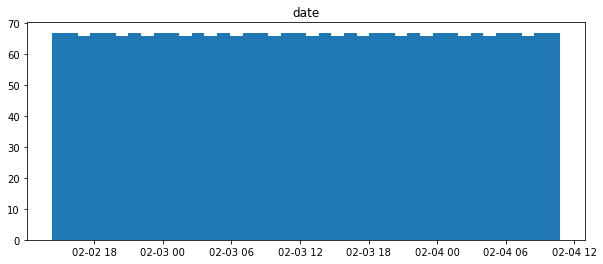

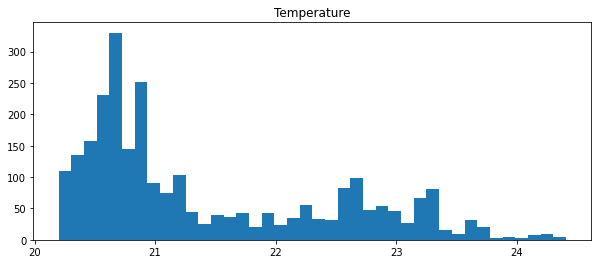

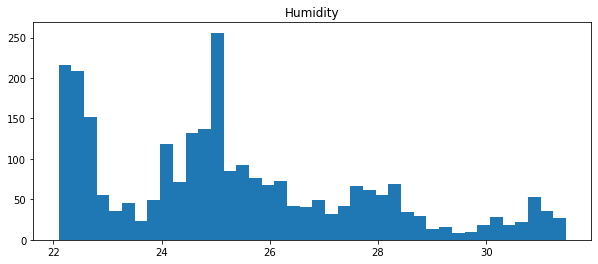

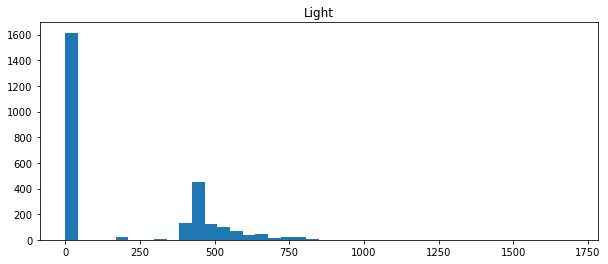

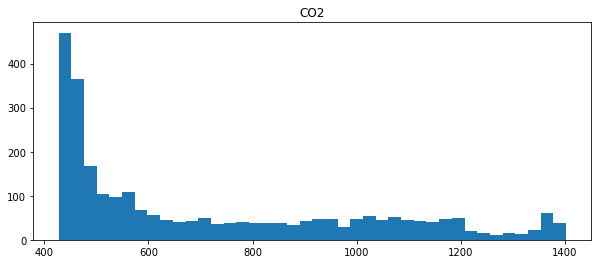

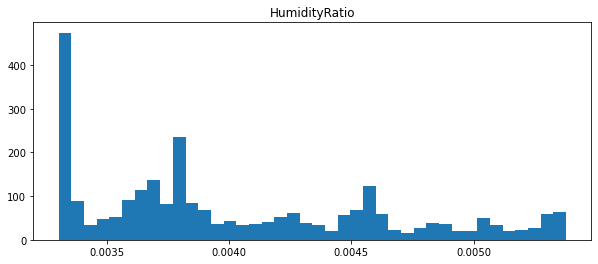

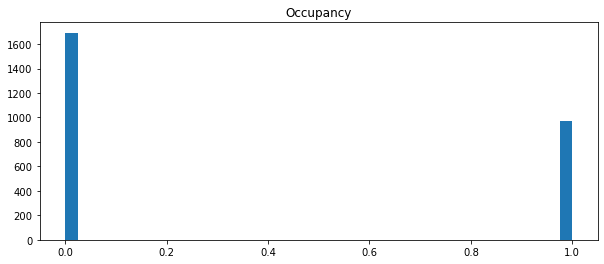

In [17]:
for key in df.keys():
    plt.figure(figsize=(10, 4))
    plt.hist(df[key], bins=40)
    plt.title(key)

In [18]:
# we can see that the data is slightly imbalanced in favour of Occupancy = 0.
# The data is also not uniform across the dependent variables
# This gives you an idea of when the model should be uncertain (MACEst)
# for example there are clear gaps in Light levels between 0 and 500 however this could just be the minimum brightness in the rooms that are used and not that much of an issue.

In [19]:
# we can easily look at the distributions as a function of day

In [31]:
# how many observations on each day?
print(df[df['date'].dt.day == 2].shape)
print(df[df['date'].dt.day == 3].shape)
print(df[df['date'].dt.day == 4].shape)

(581, 7)
(1440, 7)
(644, 7)


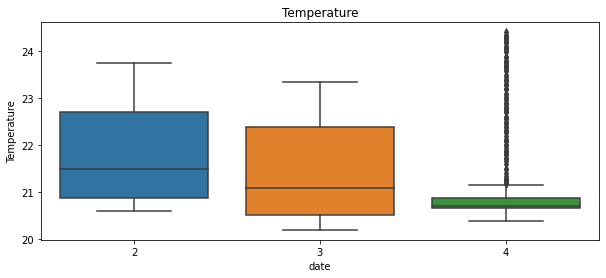

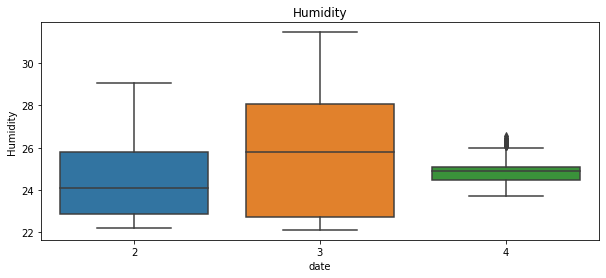

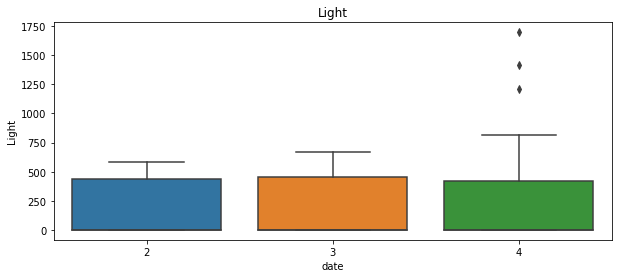

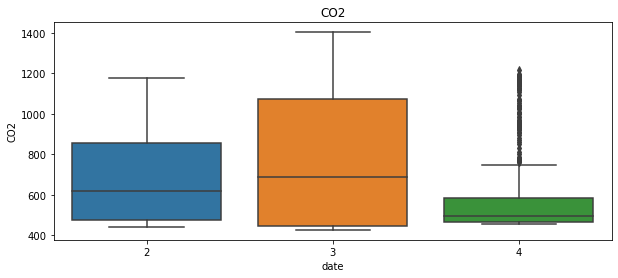

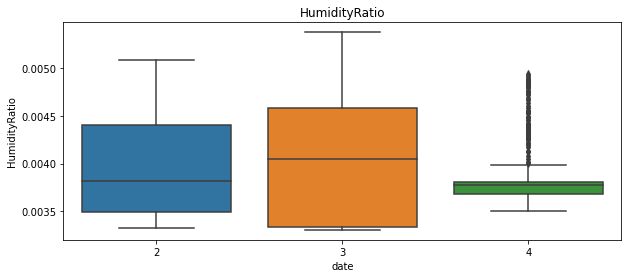

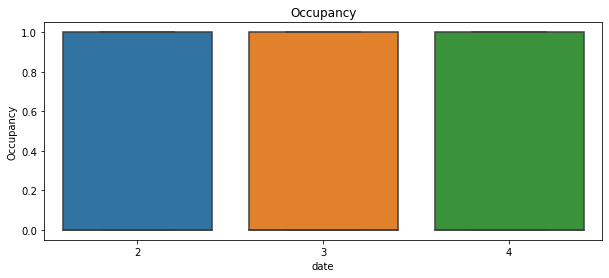

In [26]:
for key in df.keys():
    if key != "date":
        plt.figure(figsize=(10, 4))
        sns.boxplot(x=df['date'].dt.day, y=df[key])
        plt.title(key)
        plt.show()
        plt.close()

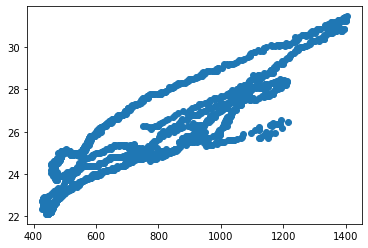

In [34]:
plt.figure()
plt.scatter(df["CO2"], df["Humidity"])

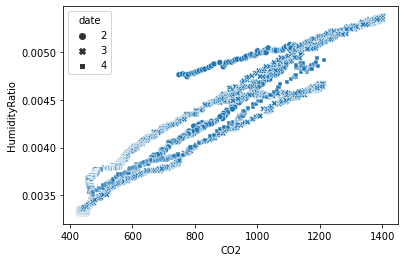

In [37]:
ax = sns.scatterplot(x=df["CO2"], y=df["HumidityRatio"], style=df['date'].dt.day)

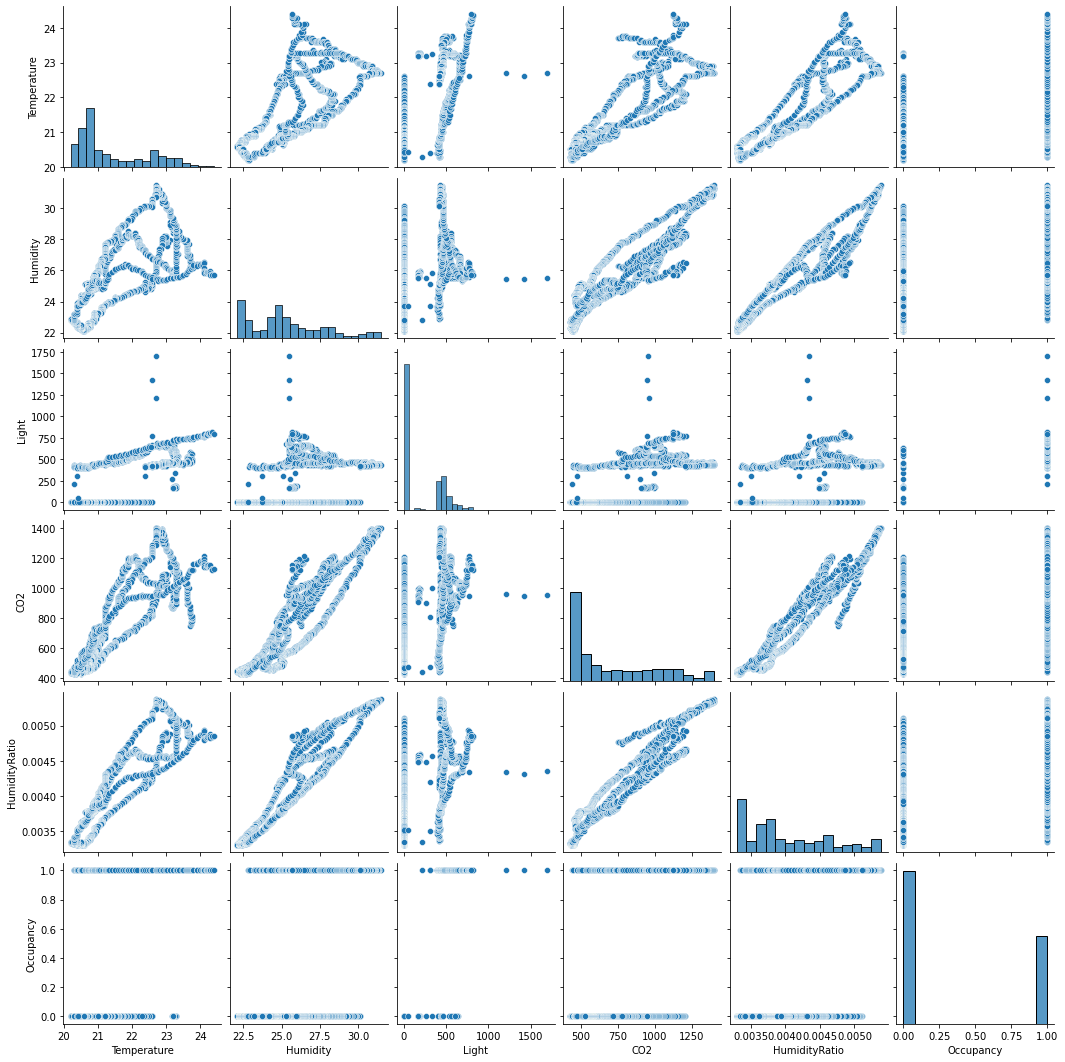

In [38]:
ax = sns.pairplot(df)

In [ ]:
# from this we see that there are visible correlations - this might allow us to reduce the number
# of input features we use
# from eyeballing this I think using "Light" and "CO2" might be good predictors of "Occupancy"

In [ ]:
# we can quantify the correlation

In [54]:
np.array(corr)

array([[1.        , 0.7169882 , 0.76842787, 0.87022647, 0.8945481 ],
       [0.7169882 , 1.        , 0.5619048 , 0.91161058, 0.95191354],
       [0.76842787, 0.5619048 , 1.        , 0.76916746, 0.69328598],
       [0.87022647, 0.91161058, 0.76916746, 1.        , 0.96444019],
       [0.8945481 , 0.95191354, 0.69328598, 0.96444019, 1.        ]])

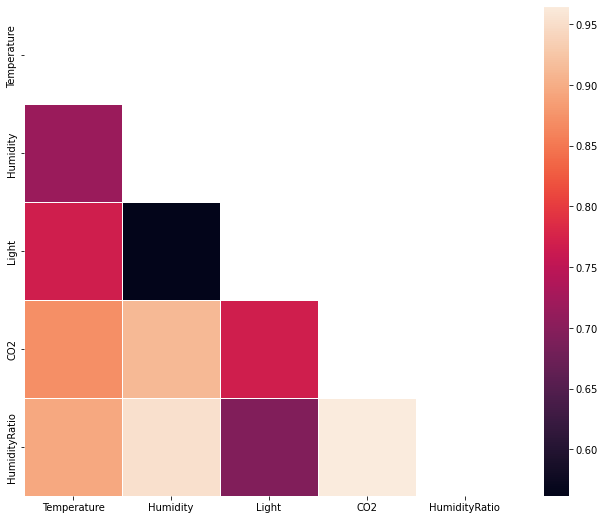

In [50]:
corr = df.iloc[:, 1:-1].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
fig, ax = plt.subplots(figsize=(11, 9))
ax = sns.heatmap(corr, mask=mask, square=True, linewidths=0.5)